In [1]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from datetime import datetime
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.evaluation import BinaryClassificationMetrics
%matplotlib inline

In [2]:
train=pd.read_csv("datatraining.txt")
#Convert string to datetime format and set it as index
train['date']=train['date'].map(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
train.set_index('date', inplace=True)

test=pd.read_csv("datatest.txt")
test['date']=test['date'].map(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
test.set_index('date', inplace=True)

train.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


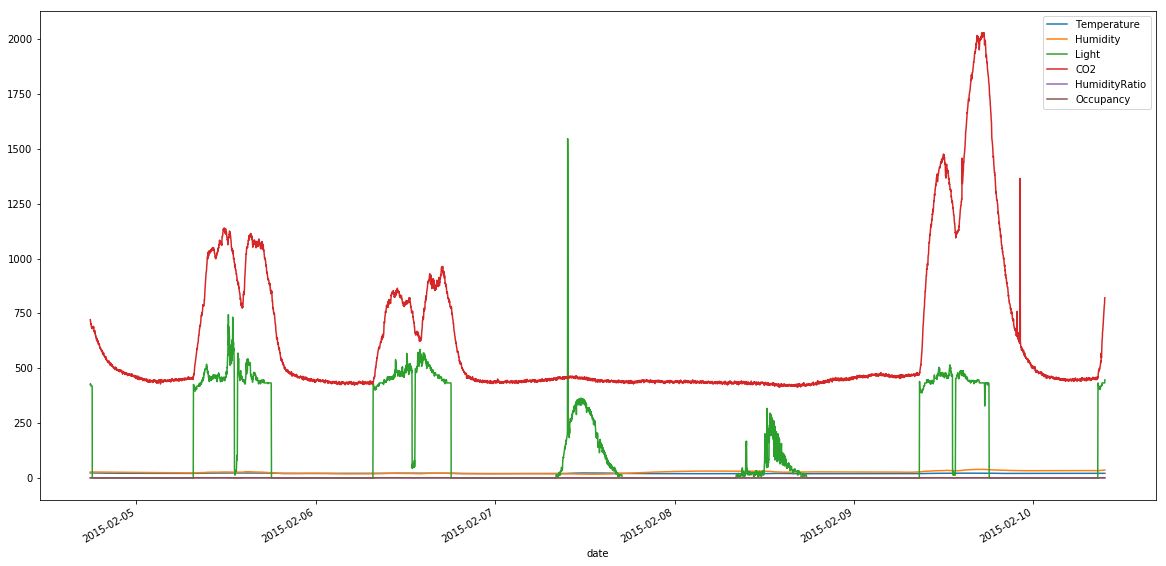

In [3]:
#Plot all parameters with respect to date
train.plot(figsize=(20,10))

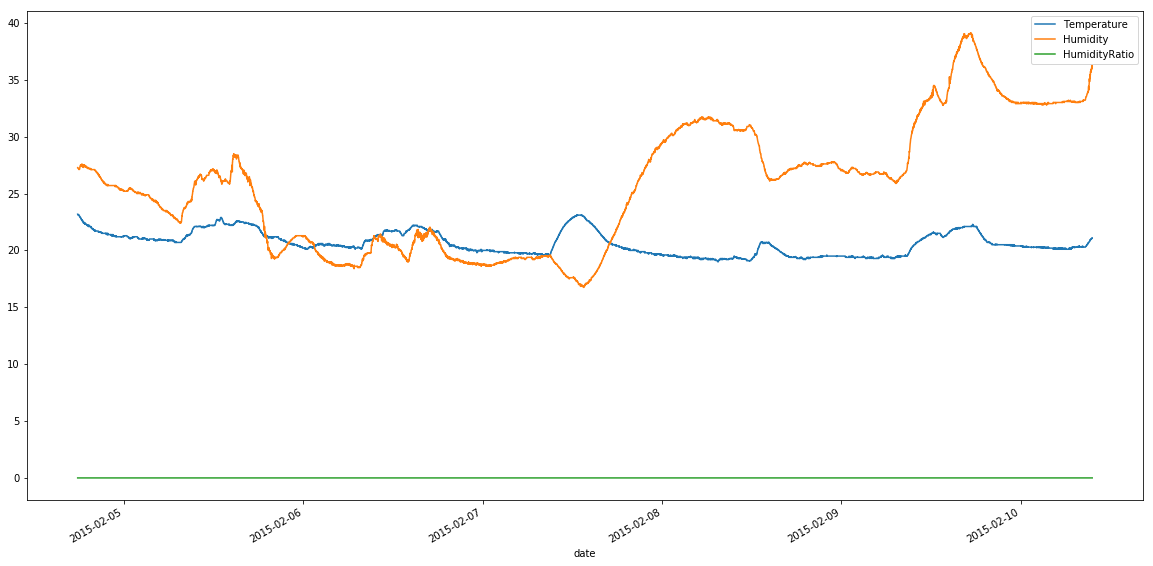

In [4]:
train[['Temperature', 'Humidity', 'HumidityRatio']].plot(figsize=(20,10))

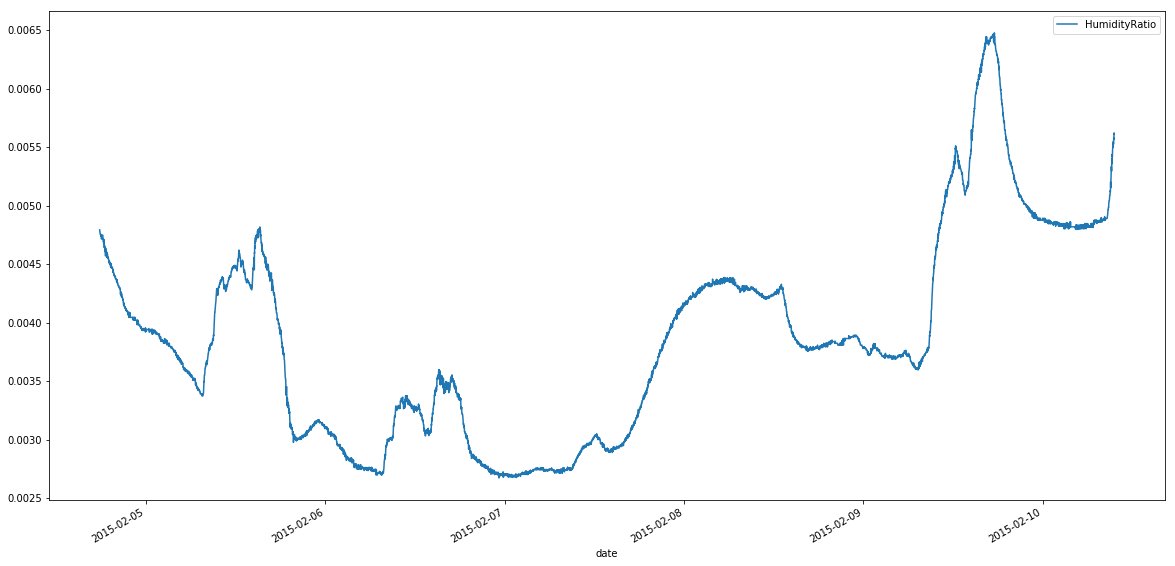

In [5]:
train[['HumidityRatio']].plot(figsize=(20,10))
#Parameters vary at different scales

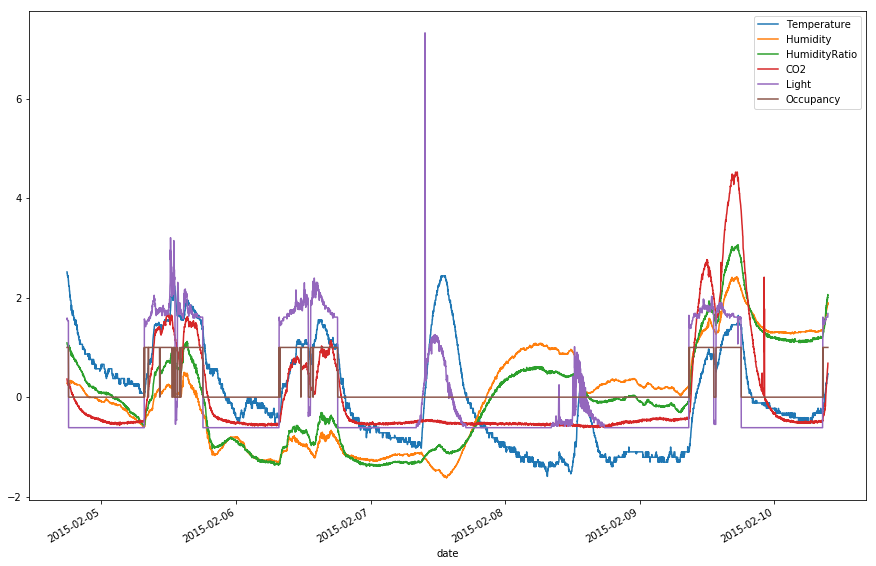

In [6]:
#Scale all parameters 
normalized_train=pd.DataFrame(preprocessing.scale(train[['Temperature', 'Humidity', 'HumidityRatio','CO2','Light']]), columns=['Temperature', 'Humidity', 'HumidityRatio','CO2','Light'])
normalized_train['date']=train.index.values
l=[]
for occ in train.Occupancy:
    l.append(occ)
normalized_train['Occupancy']=l
normalized_train.set_index('date', inplace=True)
normalized_train.plot(figsize=(15,10))

normalized_test=pd.DataFrame(preprocessing.scale(test[['Temperature', 'Humidity', 'HumidityRatio','CO2','Light']]), columns=['Temperature', 'Humidity', 'HumidityRatio','CO2','Light'])
normalized_test['date']=test.index.values
l=[]
for occ in test.Occupancy:
    l.append(occ)
normalized_test['Occupancy']=l
normalized_test.set_index('date', inplace=True)


In [7]:
sc=pyspark.SparkContext()

#Pyspark context

In [8]:
#RDD for train and test data (without headers)
train_rdd=sc.parallelize(normalized_train.as_matrix())
test_rdd=sc.parallelize(normalized_test.as_matrix())
test_rdd.take(5)

[array([2.20476235, 0.37681367, 1.20754022, 0.10694007, 1.56686218,
        1.        ]),
 array([2.22227495, 0.38420166, 1.22146086, 0.14521407, 1.53968001,
        1.        ]),
 array([2.23395002, 0.35957501, 1.20916118, 0.17688126, 1.51676171,
        1.        ]),
 array([2.2266531 , 0.31647838, 1.17413962, 0.19425264, 1.20130193,
        1.        ]),
 array([2.25730015, 0.34726169, 1.21152244, 0.20877626, 1.18071543,
        1.        ])]

In [9]:
#Create labelled points of test and train with label as occupancy value (last value) and the rest as the features
labelledpoint_train=train_rdd.map(lambda seq: LabeledPoint(seq[-1],seq[:-2]))
labelledpoint_test=test_rdd.map(lambda seq: LabeledPoint(seq[-1],seq[:-2]))

In [10]:
#Build logistic regression model on training set
model = LogisticRegressionWithLBFGS.train(labelledpoint_train)

In [11]:
#use model to predict values for test set and store with actual labels 
predictionAndLabels = labelledpoint_test.map(lambda lp: (float(model.predict(lp.features)), lp.label))
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC %f" %metrics.areaUnderROC)

#Area under ROC -  Accuracy is measured by the area under the ROC curve.
#An area of 1 represents a perfect test; an area of .5 represents a worthless test. 

Area under ROC 0.865467


In [12]:
numofyandno=pd.Series([x for x in predictionAndLabels.collect()])
print("Confusion matrix ")
print(numofyandno.value_counts())
count=list(numofyandno.value_counts())

print("\nAccuracy: %f" %(((count[0]+count[1])/sum(count))*100))


Confusion matrix 
(0.0, 0.0)    1443
(1.0, 1.0)     854
(1.0, 0.0)     250
(0.0, 1.0)     118
dtype: int64

Accuracy: 86.191370


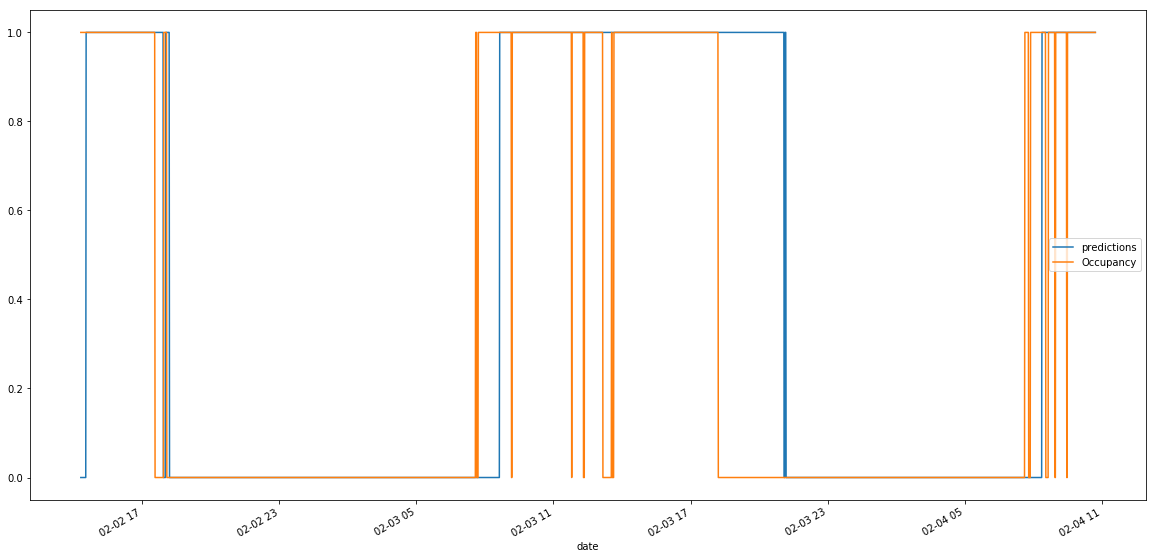

In [13]:
pred=pd.DataFrame(predictionAndLabels.collect(), columns=(['predictions', 'labels']))
normalized_test['predictions']=[x for x in pred['predictions']]
normalized_test[['predictions', 'Occupancy']].plot(figsize=(20,10))
#Plot of predicted values to actual values of occupancy for test data